# CQF - Exam 2

### Imports

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

<AxesSubplot:>

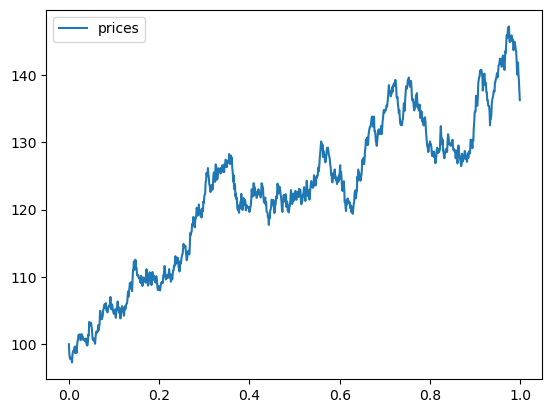

In [196]:
S0 = 100
T = 1
sigma = 0.2
r = 0.05
N = 1000
dt = T / N
ts = np.arange(0, T, dt)
dB = np.sqrt(dt) * np.random.randn(N)

S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

df = pd.DataFrame(index=ts, data=S, columns=['prices'])
df.plot()

### Milstein schema

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

<AxesSubplot:>

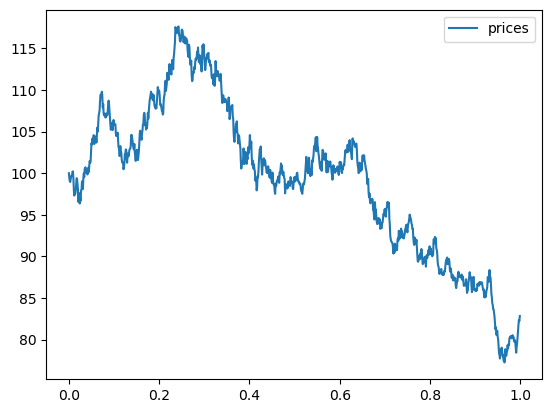

In [240]:
S0 = 100
T = 1
sigma = 0.2
r = 0.05
N = 1000
dt = T / N
ts = np.arange(0, T, dt)
dB = np.sqrt(dt) * np.random.randn(N)

S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
        + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

df = pd.DataFrame(index=ts, data=S, columns=['prices'])
df.plot()

### Closed Form Solution

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t)}
$$

<AxesSubplot:>

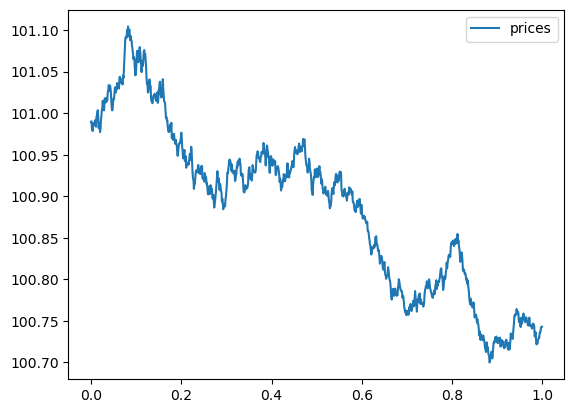

In [257]:
S0 = 100
T = 1
sigma = 0.2
r = 0.05
N = 1000
dt = T / N
ts = np.arange(0, T, dt)
dB = np.sqrt(dt) * np.random.randn(N)
B = dB.cumsum()

S = S0 + np.exp((r-0.5*sigma**2)*ts + sigma*B)

df = pd.DataFrame(index=ts, data=S, columns=['prices'])
df.plot()